In [1]:
import os, sys

import numpy as np
import pandas as pd

import anndata
import scanpy as sc
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt

In [2]:
path = '/Users/busracagirici/Documents/scrnaseq/citeseq/'
save_tables = '/Users/busracagirici/Documents/scrnaseq/citeseq/tables/'
save_figures = '/Users/busracagirici/Documents/scrnaseq/citeseq/figures/'

adata = sc.read_h5ad(path + 'data/merged_dengue_and_covid_all.h5ad')

filtered = adata[(adata.obs.Dataset.isin(['Children_viscRNAseq', 'Adults_citeseq'])) & 
                 (adata.obs.cell_quality == 'high')]

filtered = filtered[(filtered.obs.ID.isin(['1-056-01', '1-172-01', '1_003_1', '1_053_01', '1_183_01',
                                          '1_001_1', '1_013_01', '1_026_02', '1_036_02', '5_049_01',
                                           '1_019_01', '6_023_01', '5_030_01', '5_193_01', '5_154_01', 
                                            '6_001_01', '5_041_01', '1_140_01', '1_144_01', '5_044_01', 
                                            '1_002_01', '1_113_01', '5_010_01', '5_130_01'
                                          ]))].copy()

sc.pp.normalize_total(filtered, target_sum=1e6)
sc.pp.log1p(filtered, base=2)
filtered.raw = filtered

filtered

AnnData object with n_obs × n_vars = 147194 × 42244
    obs: 'Age', 'Condition', 'DENV_minus', 'DENV_plus', 'DENV_reads', 'Gender', 'ID', 'batch', 'cell_quality', 'cell_subtype', 'cell_subtype_2', 'cell_subtype_zhiyuan', 'cell_type', 'cell_type_zhiyuan', 'cell_type_new_2', 'doublets', 'mt_frac', 'n_counts', 'n_genes', 'platform', 'viral_load_nano', 'viral_load_qpcr', 'Dengue_exposure', 'cell_subtype_luca', 'cell_subtype_new', 'cell_type_luca', 'cell_type_new', 'cell_subtype_NK', 'Dataset', 'Admission', 'Sample', 'Stage', 'Experiment', 'Date', 'Date of symptoms onset', 'Days', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublets', 'mad_prd', 'n_proteins_by_counts', 'total_counts_adt', 'total_counts_log1p', 'total_counts_adt_log1p', 'rna_quality', 'protein_quality', 'high_quality', 'TCR_umi', 'TCR_umi_log1p', 'TCR_IR_VJ_2_c_call', 'TCR_IR_VDJ_2_c_call', 'TCR_IR_VJ_2_d_call', 'TCR_IR_VDJ_2_d_call', 'TCR_IR_VJ_2_v_call', 'TCR_IR_VDJ_

In [3]:
def sample_and_compare(adata1, adata2, n_sample=0, n=100, log1p=2):
    
    from random import sample
    if n_sample == 0: n_sample = min(adata1.shape[0], adata2.shape[0])

    var_names = [x for x in adata1.var_names if x in adata2.var_names]
    results = pd.DataFrame(np.zeros((n, len(var_names)), np.float64),
                           columns=var_names,
                          )

    for x in np.arange(n):
        # w/o replacement
        samplelist1 = sample(list(adata1.obs_names), n_sample)
        samplelist2 = sample(list(adata2.obs_names), n_sample)
        
        adata_1 = adata1[np.in1d(adata1.obs.index, samplelist1),:]
        adata_2 = adata2[np.in1d(adata2.obs.index, samplelist2),:]
        
        # Compute averages
        avg1 = adata_1.X.mean(axis=0)
        avg2 = adata_2.X.mean(axis=0)
        
        # Compute log2 fold changes
        if log1p is False: log2_fc = np.log2(avg1 + 1) - np.log2(avg2 + 1)
        elif log1p not in (True, 2): log2_fc = (avg1 - avg2) / np.log2(log1p)
        else: log2_fc = avg1 - avg2
        
        results.loc[x] = log2_fc

    return results


def boxplot_from_log2FC(log2FCs, title='all_cell_types', xlim=3, cbar_label= 'log2 fold change \n(VHCs vs bystanders)\n24h_infected_DMSO', height=5, aspect = 0.5, vmin=-1.5, vmax = 1.5):
    import matplotlib as mpl
    fig, ax = plt.subplots(figsize=[height*aspect, height])
    cmap = sns.diverging_palette(245, 5, as_cmap=True)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    palette = [cmap(norm(x)) for x in np.clip(log2FCs.median(axis=0), vmin, vmax)]
    sns.boxplot(data=log2FCs, orient="h", ax=ax, palette=palette)
    ax.set_title(title)
    ax.set_xlim(xlim*-1, xlim)
    ax.tick_params(labelsize=12)
    #ax.set_xticks([str(x) for x in np.linspace(vmin,vmax,1)])
    for x in [-1, 0, 1]:
        ax.axvline(x, c='black', ls='-.', lw=0.5, zorder=0.5)
    
    ax_cb = fig.add_axes([0.15, 0.04, 0.65, 0.02])
    cbar = mpl.colorbar.ColorbarBase(ax_cb, norm=norm, cmap=cmap, orientation='horizontal')
    cbar.set_ticks(list(range(vmin, vmax+1, 1)))
    cbar.set_ticklabels([str(x) for x in list(range(vmin, vmax+1, 1))])
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(cbar_label)

    return fig, ax
#fig.tight_layout()
#data_path = '/Users/busracagirici/Documents/scrnaseq/organ_lung_data/'
#fig.savefig(data_path + 'results/figures/24h_infected_RMC113_box_DEGs_VHCs_autophagy_more_than_3vRNAs.pdf', bbox_inches='tight')

In [4]:
filtered = filtered[filtered.obs.Condition == 'SD']
sc.pp.filter_genes(filtered, min_cells=3)
filtered.obs.Dengue_exposure.cat.categories

Index(['Primary', 'Secondary'], dtype='object')

In [5]:
filtered.obs.groupby(['Condition', 'Dataset', 'Dengue_exposure']).size()

Condition  Dataset              Dengue_exposure
SD         Adults_citeseq       Primary            14764
                                Secondary          20541
           Children_viscRNAseq  Primary             6048
                                Secondary          30130
dtype: int64

In [6]:
from matplotlib import rcParams
rcParams['font.size']=12

ct = 'Monocytes'
newdata = filtered[filtered.obs.cell_type_new == ct].copy()

cond='Dengue_exposure'
sample1 = 'Secondary'
sample2 = 'Primary'
n_sample = 0

adata1 = newdata[newdata.obs[cond] == sample1].copy()
#adata1 = adata1[:,genes].copy()

adata2 = newdata[newdata.obs[cond] == sample2].copy()
#adata2 = adata2[:,genes].copy()


log2fc_temp = sample_and_compare(adata1, adata2, n_sample=n_sample, n=100, log1p=2)


In [7]:
medpair = pd.DataFrame(log2fc_temp.median())
medpair

,0
A1BG,-0.029249
A1BG-AS1,0.008823
A1CF,0.000000
A2M,-0.008099
A2M-AS1,-0.007439
...,...
ZXDC,-0.394750
ZYG11A,0.002235
ZYG11B,-0.022628
ZYX,0.681197


In [8]:
medpair.sort_values(by=0)

,0
Hu.CD41,-8.606747
HuMs.CD49f,-7.557424
Hu.CD58,-7.339811
Hu.CLEC12A,-7.268677
Hu.CD29,-7.235512
...,...
IFITM1,2.745233
PCBP2,2.981219
S100A12,2.992734
C8orf59,3.258026


In [9]:
medpair[abs(medpair[[0]]) >1].dropna()

,0
ABCA1,-1.373506
ABRACL,1.544454
AC007384.1,-1.141147
AC007952.4,-2.800806
AC009226.1,-1.058693
...,...
ZFAND3,-1.939739
ZFP36L1,-1.185018
ZNF267,-1.215286
ZNHIT1,1.081667


In [10]:
list(medpair[abs(medpair[[0]]) >1].dropna().index)

['ABCA1',
 'ABRACL',
 'AC007384.1',
 'AC007952.4',
 'AC009226.1',
 'AC009522.1',
 'AC012447.1',
 'AC013652.1',
 'AC020916.1',
 'AC022217.3',
 'AC073332.1',
 'AC106865.2',
 'AC139099.2',
 'AC245014.3',
 'AC253572.2',
 'ACSL1',
 'ACSL5',
 'ACTB',
 'ACTG1',
 'ACVR2A',
 'ADAMTSL4-AS1',
 'ADK',
 'AES',
 'AGTRAP',
 'AHR',
 'AIF1',
 'AL021155.5',
 'AL138720.1',
 'AL138963.4',
 'AL691403.1',
 'ALDOA',
 'ALYREF',
 'ANKHD1',
 'ANKRD11',
 'ANKRD44',
 'ANTKMT',
 'ANXA1',
 'ANXA5',
 'ANXA6',
 'AOAH',
 'AP003086.1',
 'AP1S2',
 'AP2S1',
 'APBB1IP',
 'ARF1',
 'ARF5',
 'ARHGAP15',
 'ARHGAP26',
 'ARHGDIB',
 'ARID4B',
 'ARIH1',
 'ARL15',
 'ARL6IP5',
 'ARPC2',
 'ARPC3',
 'ARPC5',
 'ASGR1',
 'ASNA1',
 'ATF3',
 'ATG7',
 'ATOX1',
 'ATP2B1',
 'ATP2B1-AS1',
 'ATP5F1A',
 'ATP5F1C',
 'ATP5MC1',
 'ATP5MC3',
 'ATP5MD',
 'ATP5ME',
 'ATP5MF',
 'ATP5MPL',
 'ATP5PB',
 'ATP5PD',
 'ATP5PF',
 'ATP5PO',
 'ATP6V0B',
 'ATP6V0C',
 'ATP6V0D1',
 'ATP6V0E1',
 'ATP6V1G1',
 'AZIN1-AS1',
 'B4GALT1',
 'BAX',
 'BCL6',
 'BLVRA',
 'BL

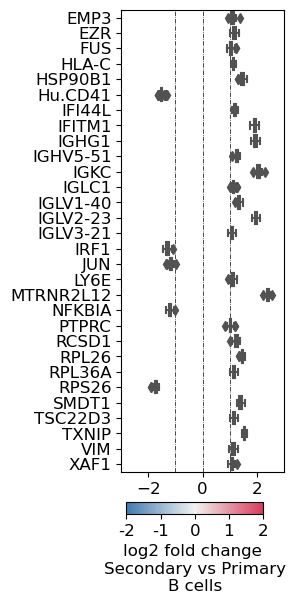

In [35]:
fig, ax = boxplot_from_log2FC(log2fc_temp[list(medpair[abs(medpair[[0]]) >1].dropna().index)], 
                              #log2fc_temp[list(medpair[abs(medpair[[0]]) >1].dropna().index)], 
                              xlim=3, vmin=-2, vmax=2,
                              title='',
                              height=6, aspect = 0.35, 
                              cbar_label= f'log2 fold change \n{sample1} vs {sample2}\n{ct}',
                             )
plt.show()


In [ ]:
import gseapy as gp
from gseapy import barplot, dotplot

genes_all = df_ct[abs(df_ct)>=1].index.to_list()
enrich_all = gp.enrichr(gene_list=genes_all,
                     gene_sets=['GO_Biological_Process_2021', 
                               #'MSigDB_Hallmark_2020', 
                                #'KEGG_2021_Human', 
                               ],
                     cutoff = 0.5)
ax = barplot(enrich_all.res2d,title=f'{ct}', 
             figsize=(4, 5), 
             top_term=20,
             color='darkred')
plt.show()


In [24]:
medpair[abs(medpair[[0]]) >1].dropna()

,0
EMP3,1.070883
EZR,1.151466
H2AFZ,1.003995
HLA-C,1.132732
HSP90B1,1.445362
Hu.CD41,-1.475509
IFI44L,1.205646
IFITM1,1.898069
IGHG1,1.926494
IGHV5-51,1.227718


In [40]:
genes = ['NFKBIA', 'VIM', 'EZR', 'RPL26',  'RPL36A', 'RPS26',
          'HSP90B1',  'HLA-C',  'XAF1', #'Hu.CD41',
         'IRF1', 'IFITM1', 'LY6E', 'IFI44L', 
          'TXNIP',  'JUN', 'MTRNR2L12', 'RCSD1', 'SMDT1', 'TSC22D3', 'EMP3', 'H2AFZ',
         'IGHG1', 'IGKC', 'IGLC1', 'IGLV1-40', 'IGLV2-23', 'IGLV3-21', 'IGHV5-51']


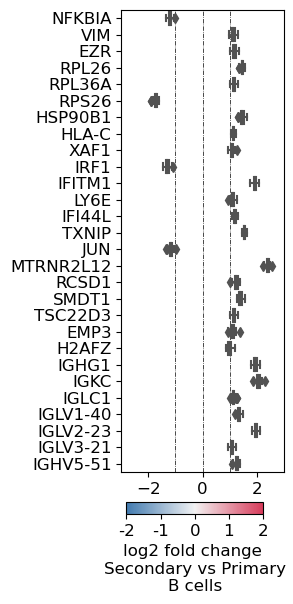

In [41]:
fig, ax = boxplot_from_log2FC(log2fc_temp[genes], 
                              #log2fc_temp[list(medpair[abs(medpair[[0]]) >1].dropna().index)], 
                              xlim=3, vmin=-2, vmax=2,
                              title='',
                              height=6, aspect = 0.35, 
                              cbar_label= f'log2 fold change \n{sample1} vs {sample2}\n{ct}',
                             )
plt.show()


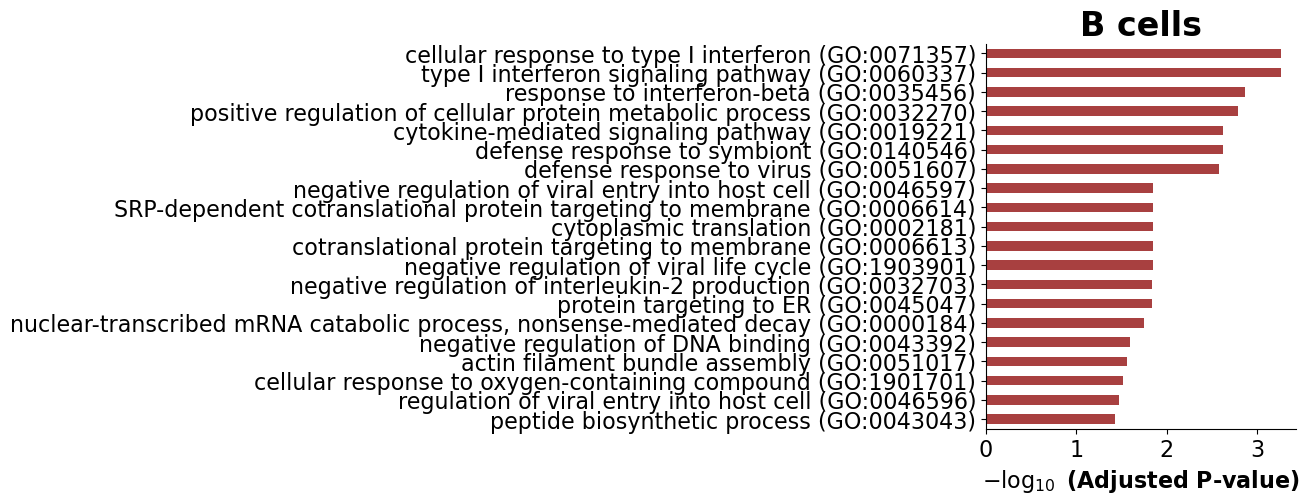

In [36]:
import gseapy as gp
from gseapy import barplot, dotplot

genes_all = list(medpair[abs(medpair[[0]]) >1].dropna().index)
enrich_all = gp.enrichr(gene_list=genes_all,
                     gene_sets=['GO_Biological_Process_2021', 
                               #'MSigDB_Hallmark_2020', 
                                #'KEGG_2021_Human', 
                               ],
                     cutoff = 0.5)
ax = barplot(enrich_all.res2d,title=f'{ct}', 
             figsize=(4, 5), 
             top_term=20,
             color='darkred')
plt.show()


In [37]:
enrich_all.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,cellular response to type I interferon (GO:007...,4/65,0.000003,0.000539,0,0,50.211854,645.483009,IFITM1;IRF1;HLA-C;XAF1
1,GO_Biological_Process_2021,type I interferon signaling pathway (GO:0060337),4/65,0.000003,0.000539,0,0,50.211854,645.483009,IFITM1;IRF1;HLA-C;XAF1
2,GO_Biological_Process_2021,response to interferon-beta (GO:0035456),3/28,0.000010,0.001339,0,0,88.644444,1023.011964,IFITM1;IRF1;XAF1
3,GO_Biological_Process_2021,positive regulation of cellular protein metabo...,4/102,0.000016,0.001629,0,0,31.196232,344.931384,NFKBIA;RPL26;VIM;EZR
4,GO_Biological_Process_2021,cytokine-mediated signaling pathway (GO:0019221),7/621,0.000029,0.002343,0,0,9.594392,100.120210,NFKBIA;IFITM1;IRF1;HLA-C;VIM;XAF1;HSP90B1
...,...,...,...,...,...,...,...,...,...,...
408,GO_Biological_Process_2021,regulation of nucleic acid-templated transcrip...,1/430,0.479264,0.483951,0,0,1.570694,1.155251,FUS
409,GO_Biological_Process_2021,regulation of cellular macromolecule biosynthe...,1/468,0.508780,0.512503,0,0,1.440080,0.973118,FUS
410,GO_Biological_Process_2021,positive regulation of cell population prolife...,1/474,0.513291,0.515788,0,0,1.421375,0.947934,PTPRC
411,GO_Biological_Process_2021,positive regulation of intracellular signal tr...,1/546,0.564385,0.565755,0,0,1.229041,0.703035,PTPRC


In [39]:
enrich_all.results.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,cellular response to type I interferon (GO:007...,4/65,0.000003,0.000539,0,0,50.211854,645.483009,IFITM1;IRF1;HLA-C;XAF1
1,GO_Biological_Process_2021,type I interferon signaling pathway (GO:0060337),4/65,0.000003,0.000539,0,0,50.211854,645.483009,IFITM1;IRF1;HLA-C;XAF1
2,GO_Biological_Process_2021,response to interferon-beta (GO:0035456),3/28,0.000010,0.001339,0,0,88.644444,1023.011964,IFITM1;IRF1;XAF1
3,GO_Biological_Process_2021,positive regulation of cellular protein metabo...,4/102,0.000016,0.001629,0,0,31.196232,344.931384,NFKBIA;RPL26;VIM;EZR
4,GO_Biological_Process_2021,cytokine-mediated signaling pathway (GO:0019221),7/621,0.000029,0.002343,0,0,9.594392,100.120210,NFKBIA;IFITM1;IRF1;HLA-C;VIM;XAF1;HSP90B1
